## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [1]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "monash_covid_deaths": {"prediction_length": 24},
    "monash_traffic": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

# dataset_choice = "monash_tourism_monthly"
# dataset_choice = "monash_covid_deaths"
dataset_choice = "monash_hospital"
num_time_series_subset = 2
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

# prediction_length = dataset_metadata[dataset_choice]['prediction_length']
prediction_length = 24
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]

In [2]:
# Apply any features which need previous target values here
from scipy.stats import linregress
import numpy as np

from tabpfn_time_series.features.feature_generator_base import (
    FeatureGenerator,
)
import pandas as pd

# Function to calculate slope of linear fit over previous 10 values (excluding current)
def compute_slope(series):
    x = np.arange(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope

class LinearTrend(FeatureGenerator):
    def generate(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # Apply function using rolling window of size 10, shifted by 1 to exclude current point
        df['linear_fit_slope'] = (
            df['target']
            .shift(1)  # exclude current value
            .rolling(window=10)
            .apply(compute_slope, raw=False)
        )
        
        return df
    
class PreviousTarget(FeatureGenerator):
    def generate(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['previous_target'] = df['target'].shift(1)
        return df
    
# Apply all feature generators
# tsdf = tsdf.groupby(level="item_id", group_keys=False).apply(LinearTrend())
tsdf = tsdf.groupby(level="item_id", group_keys=False).apply(PreviousTarget())

In [3]:
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

Let's take a look at the time series data.

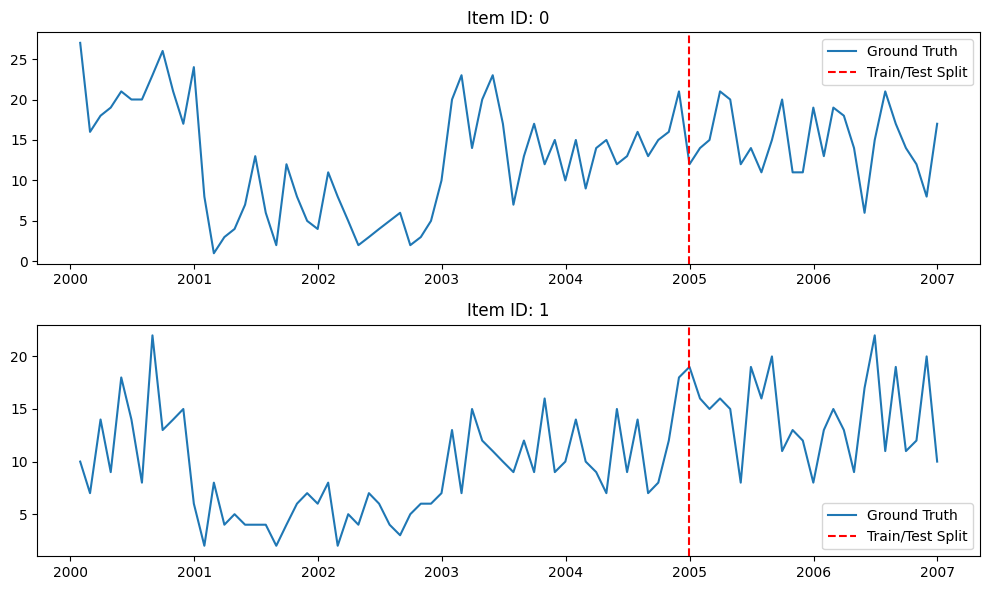

In [4]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `Running Index`, `Calendar Features`, and `Auto Seasonal Features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [5]:
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)
selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)
train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

In [371]:
# manually add the linear trend feature
# test_tsdf['linear_fit_slope'] = test_tsdf_ground_truth.loc[test_tsdf.index]['linear_fit_slope']
test_tsdf['previous_target'] = test_tsdf_ground_truth.loc[test_tsdf.index]['previous_target']

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [6]:
import torch

device = torch.device("mps")

In [7]:
from tabpfn import TabPFNRegressor

model = TabPFNRegressor(device=device)

feature_columns = test_tsdf.columns[1:]

X_train = train_tsdf[feature_columns]
y_train = train_tsdf['target']

model.fit(X_train, y_train)

X_test = test_tsdf[feature_columns]

In [15]:
for item_id, df in X_test.groupby('item_id'):
    print(item_id)

0
1


In [ ]:
from tqdm import tqdm

def predict_autogressive(model, first_target, X_test):
    predictions = []
    last_target = first_target  # Start with the first known target value
    for i in tqdm(range(len(X_test))):
        # Prepare input for the model
        X_input = X_test.iloc[i].to_frame().T
        X_input['previous_target'] = last_target  # Use the last known target value

        # Predict next value
        y_pred = model.predict(X_input)[0]
        
        # Store prediction
        predictions.append(y_pred)
        
        # Update current target for next iteration
        last_target = y_pred
        
    return predictions

predictions = []

for (item_id, train_df), (_, test_df) in zip(
    train_tsdf.groupby(level="item_id"), test_tsdf.groupby(level="item_id")
):
    print(f"Predicting for item_id: {item_id}")
    pred = predict_autogressive(model, train_df['target'].iloc[-1], test_df[feature_columns])
    predictions.append(pred)

Predicting for item_id: 0
1269.0


100%|██████████| 24/24 [00:51<00:00,  2.16s/it]


Predicting for item_id: 1
144.0


100%|██████████| 24/24 [00:50<00:00,  2.12s/it]


In [21]:
pred = np.concatenate(predictions)

In [376]:
probs = model.predict(X_test, output_type='quantiles', quantiles=[0.1, 0.5, 0.9])

## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

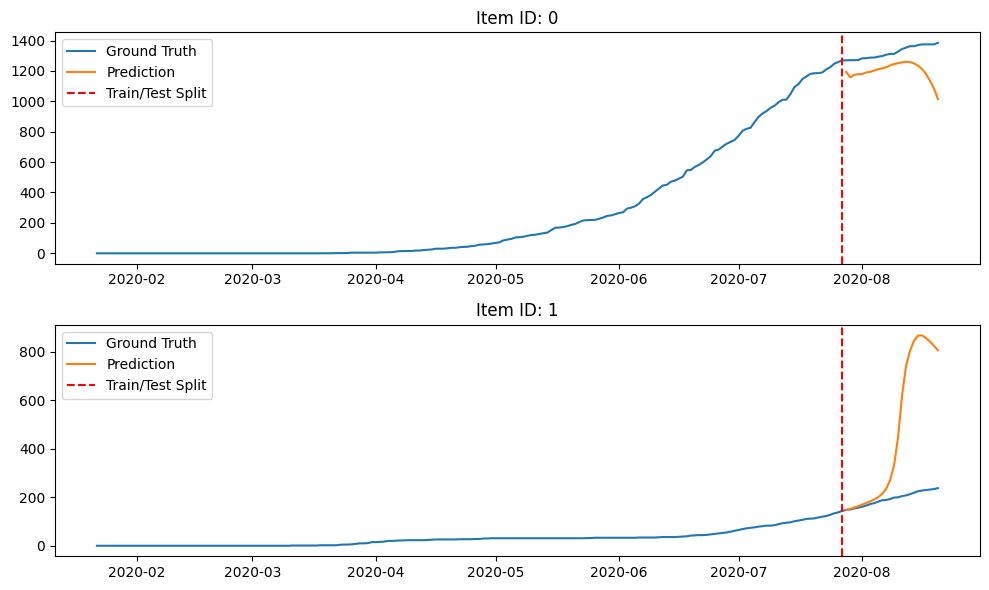

In [24]:
import pandas as pd

# pred = pd.DataFrame({
#     "target": probs[1],
#     "0.1": probs[0],
#     "0.5": probs[1],
#     "0.9": probs[2],
# }, index=test_tsdf.index)

pred = pd.DataFrame({'target': pred.tolist()}, index=test_tsdf.index)

from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth[['target']],
    pred=pred,
    show_quantiles=False,
)

# Get Embeddings

In [378]:
from tabpfn_extensions.embedding import TabPFNEmbedding
import os
os.environ['TABPFN_ALLOW_CPU_LARGE_DATASET'] = '1'  # Allow large datasets on CPU

In [381]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "monash_covid_deaths": {"prediction_length": 24},
    "monash_traffic": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
# dataset_choice = "monash_covid_deaths"
# dataset_choice = "monash_hospital"
num_time_series_subset = 2
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

# prediction_length = dataset_metadata[dataset_choice]['prediction_length']
prediction_length = 24
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

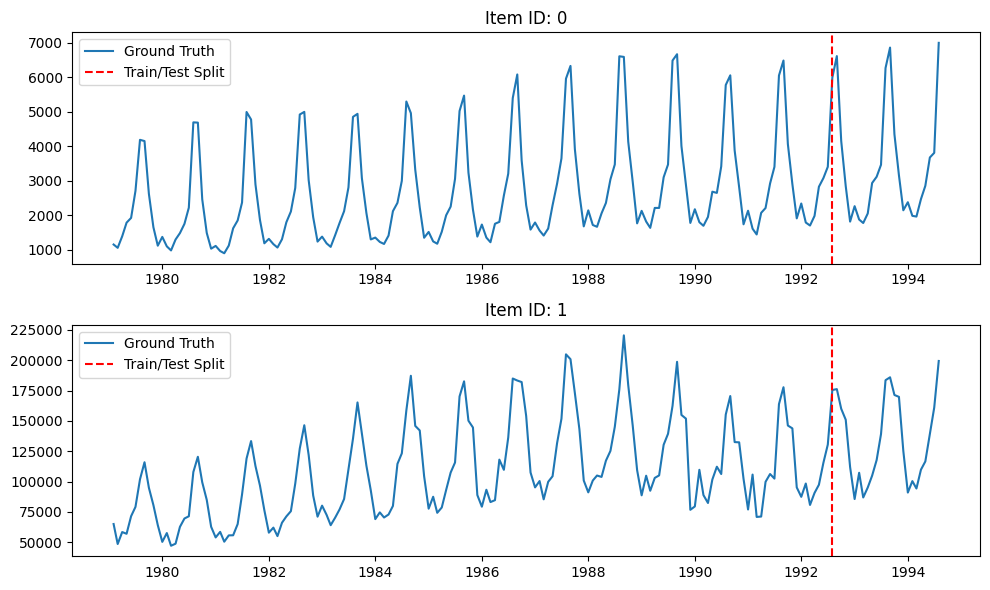

In [382]:
plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [ ]:
tsdf

(374, 1)

In [309]:
embedding_extractor = TabPFNEmbedding(tabpfn_reg=model, n_fold=0)

train_embeddings = embedding_extractor.get_embeddings(X_train, y_train, X_test, data_source="train")
test_embeddings = embedding_extractor.get_embeddings(X_train, y_train, X_test, data_source="test")

In [321]:
train_embeddings.shape

(8, 120, 192)